# 量子近似优化算法


`Linux` `CPU` `全流程` `初级` `中级` `高级`

[![](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/_static/logo_source.png)](https://gitee.com/mindspore/mindquantum/blob/master/tutorials/QAOA.ipynb)

## 概述

量子近似优化算法（Quantum Approximate Optimization Algorithm, QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本教程里，我们将利用QAOA算法来解决最大割问题(Max-Cut)，以期熟悉MindQuantum中量子线路的搭建和训练。

## 环境准备

本教程所需要的额外库：

- networks

## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边为```(0, 1), (1, 2), (2, 3), (3, 4), (0, 4)```，通过（b）图的分割，我们将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题。下面，我们介绍怎么将Max-Cut问题转化为一个哈密顿量的基态能力求解问题。

![max cut](./images/Max_Cut.png)

## Max-Cut问题量子化

这里我们将图中的每个顶点赋予一个量子比特，当顶点被分到左边时，我们将该顶点上的量子比特设置为$\left|0\right>$态，同理，右边为$\left|1\right>$态，当两个顶点被分到不同的集合中时，这两个顶点上的比特将处于不同的量子态。例如对于第0个顶点和第1个顶点，当其连线被切割是，两个顶点上的比特对应的量子态可以为$\left|\psi\right>=\left|0_11_0\right>$或$\left|\psi\right>=\left|1_10_0\right>$，其中下角标表示顶点的序号。此时，我们选择哈密顿量$H=(Z_1Z_0-1)/2$，不难发现：
$$\left<\psi\right|H\left|\psi\right>=-1$$
而当顶点被分到同一集合中是，不难验证此时：
$$\left<\psi\right|H\left|\psi\right>=0$$
因此，我们只用按照上面的规则，写出图对应的哈密顿量$H$，利用量子计算机求得$H$的基态能量与基态，我们就可以得到该图的Max-Cut切割方案与最大切割边数。我们记所有边的集合为$C$，所有边个数为$c$，则哈密顿量可写为：
$$H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$$

In [2]:
from mindquantum import Circuit, Hamiltonian, UN, H,ZZ,RX,StateEvolution
from mindquantum.nn import MindQuantumAnsatzOnlyLayer
from mindquantum.ops import QubitOperator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/home/xuxs/gitee/mindquantum/mindquantum/__init__.py:48: UserWarning: [NOTE] Current simulator thread is 16. If your simulation is slow, set OMP_NUM_THREADS to a appropriate number according to your model.
  omp_num_threads))


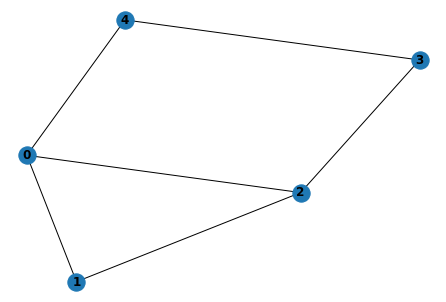

In [2]:
g=nx.Graph()
nx.add_path(g,[0,1])
nx.add_path(g,[1,2])
nx.add_path(g,[2,3])
nx.add_path(g,[3,4])
nx.add_path(g,[0,4])
nx.add_path(g,[0,2])
nx.draw(g,with_labels=True,font_weight='bold')

## 搭建QAOA量子线路

In [3]:
def build_hc(g,para):
    hc=Circuit()
    for i in g.edges:
        hc+=ZZ(para).on(i)
    return hc

def build_hb(g,para):
    hc=Circuit()
    for i in g.nodes:
        hc+=RX(para).on(i)
    return hc

def build_ham(g):
    hc=QubitOperator()
    for i in g.edges:
        hc+=QubitOperator(f'Z{i[0]} Z{i[1]}')
    return hc

def build_ansatz(g,p):
    c=Circuit()
    for i in range(p):
        c+=build_hc(g,f'g{i}')
        c+=build_hb(g,f'b{i}')
    return c

In [4]:
p=4
ham = Hamiltonian(build_ham(g))
ansatz = build_ansatz(g,p)
init_state_circ = UN(H, g.nodes)

In [5]:
net = MindQuantumAnsatzOnlyLayer(ansatz.para_name, init_state_circ+ansatz,ham)

In [6]:
opti = nn.Adam(net.trainable_params(),learning_rate=0.05)

In [7]:
train_net = nn.TrainOneStepCell(net, opti)

## 训练并展示结果

In [8]:
for i in range(600):
    if i%10 == 0:
        print("train step:", i, ", cut:", (len(g.edges)-train_net())/2)

train step: 0 , cut: [[2.9962018]]
train step: 10 , cut: [[2.926842]]
train step: 20 , cut: [[3.1553357]]
train step: 30 , cut: [[3.5062845]]
train step: 40 , cut: [[3.866898]]
train step: 50 , cut: [[4.0665703]]
train step: 60 , cut: [[4.140947]]
train step: 70 , cut: [[4.1416097]]
train step: 80 , cut: [[4.103196]]
train step: 90 , cut: [[4.1120386]]
train step: 100 , cut: [[4.196638]]
train step: 110 , cut: [[4.3144426]]
train step: 120 , cut: [[4.404308]]
train step: 130 , cut: [[4.440242]]
train step: 140 , cut: [[4.4536867]]
train step: 150 , cut: [[4.486898]]
train step: 160 , cut: [[4.548495]]
train step: 170 , cut: [[4.6175323]]
train step: 180 , cut: [[4.666423]]
train step: 190 , cut: [[4.681896]]
train step: 200 , cut: [[4.6730976]]
train step: 210 , cut: [[4.661927]]
train step: 220 , cut: [[4.6660852]]
train step: 230 , cut: [[4.690404]]
train step: 240 , cut: [[4.7281966]]
train step: 250 , cut: [[4.766745]]
train step: 260 , cut: [[4.79385]]
train step: 270 , cut: [[4.8

In [9]:
pr = dict(zip(ansatz.para_name,net.weight.asnumpy()))

In [10]:
print(StateEvolution(init_state_circ+ansatz).final_state(pr,ket=True))

(0.006099223624914885+0.00788161065429449j)¦00000⟩
(-0.034017495810985565+0.0021149481181055307j)¦00001⟩
(-0.002445211401209235-0.02516593411564827j)¦00010⟩
(-0.01259702816605568+0.0018445311579853296j)¦00011⟩
(-0.034017495810985565+0.0021149481181055307j)¦00100⟩
(0.07298118621110916-0.1288059800863266j)¦00101⟩
(-0.01259702816605568+0.0018445311579853296j)¦00110⟩
(-0.013409003615379333+0.007149304263293743j)¦00111⟩
(0.0038311604876071215+0.006157764699310064j)¦01000⟩
(-0.48016485571861267+0.023700367659330368j)¦01001⟩
(-0.009163610637187958-0.07471536844968796j)¦01010⟩
(-0.48016485571861267+0.023700367659330368j)¦01011⟩
(-0.015431646257638931-0.01248056162148714j)¦01100⟩
(-0.009163610637187958-0.07471536844968796j)¦01101⟩
(-0.015431646257638931-0.01248056162148714j)¦01110⟩
(0.0038311604876071215+0.006157764699310064j)¦01111⟩
(0.0038311604876071215+0.006157764699310064j)¦10000⟩
(-0.015431646257638931-0.01248056162148714j)¦10001⟩
(-0.009163610637187958-0.07471536844968796j)¦10010⟩
(-0.01

In [11]:
def show_amp(state):
    amp = np.abs(state)**2
    n_qubits = int(np.log2(len(amp)))
    labels = [bin(i)[2:].zfill(n_qubits) for i in range(len(amp))]
    plt.bar(labels, amp)
    plt.xticks(rotation=45)
    plt.show()

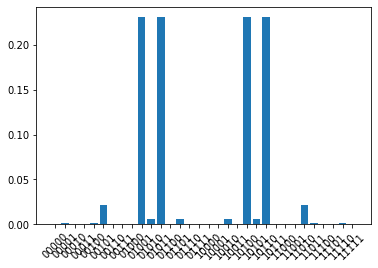

In [12]:
state = StateEvolution(init_state_circ+ansatz).final_state(pr)
show_amp(state)

## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)